This notebook is about the implementation of Stochastic Weight Averaging Gaussian from the paper [A simple baseline for Bayesian Uncertainty in Deep Learning](https://arxiv.org/abs/1902.02476), a very interesting technique to model uncertainty in deep learning relying on stochastic weight averaging to approximate the posterior distribution of the model's weights $p(\theta | D)$.

# Stochastic Weigh Averaging.

Before diving into the Bayesian learning aspect, let's first review Stochastic Weight Averaging (SWA) as proposed in the paper [Averaging Weights Leads to Wider Optima and Better Generalization](https://arxiv.org/abs/1803.05407). 

With this method, we start from a pretrained model with parameters $\hat{w}$. From this initial solution, training continues with a cyclical (or constant) relatively high learning rate. This approach allows us to explore the loss landscape, capturing snapshots of the model parameters $w_i$ at different points in the loss space. After traversing this space, we average all the captured models to obtain the final set of weights $\theta_{swa}$.

Here is the algorithm for SWA. 

![SWA](SWA.png)

In [2]:
import torch 
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

# Data generation for regression

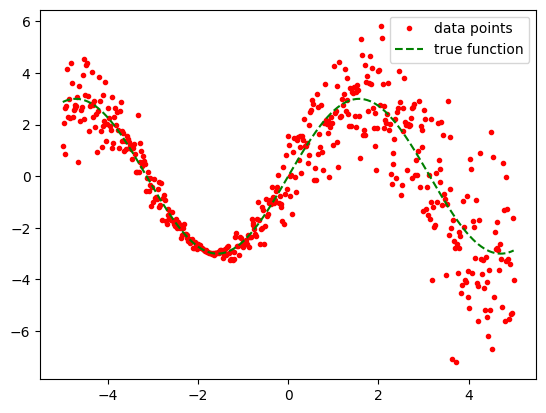

In [3]:
torch.manual_seed(1355)
X = torch.linspace(-5, 5, 500).unsqueeze(1)

noise = (0.7 + 2 * torch.sin(0.2 * X))  
y = 3 * torch.sin(X) + torch.randn(X.size()) * noise

train_set = TensorDataset(X, y)

plt.plot(X, y, 'r.', label='data points')
plt.plot(X, 3*torch.sin(X), 'g--', label='true function')
plt.legend()

## Model

This is a basic ReLU neural network with three dense layers. The model includes two additional methods to retrieve all weights as a 1D vector and to load a 1D vector into the model parameters, which will be helpful for following algorithms.

In [4]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = torch.nn.Linear(1, 10)
        self.dense2 = torch.nn.Linear(10, 10)
        self.dense3 = torch.nn.Linear(10, 1) 

    def forward(self, x):
        out = self.dense1(x)
        out = torch.nn.functional.relu(out)
        out = self.dense2(out)
        out = torch.nn.functional.relu(out)
        out = self.dense3(out)

        return out
        
    def load_flattened_weights(self, flattened_weights):
        idx = 0
        with torch.no_grad():
            for param in self.parameters():
                num_w = param.numel()
                vec = flattened_weights[idx:idx+num_w]
                param.copy_(vec.view_as(param))
                
                idx += num_w
    
    def get_weight_vector(self):
        return torch.cat([params.view(-1) for params in self.parameters()])

Let's pretrain our model $\hat{w}$

In [58]:
epochs = 100

In [59]:
pre_train_model = Model().to(device)
optimizer = torch.optim.SGD(pre_train_model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
        
for epoch in tqdm(range(epochs)):
    pre_train_model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = pre_train_model(inputs)
        loss = criterion(outputs, targets) 

        loss.backward() 
        optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.72it/s]


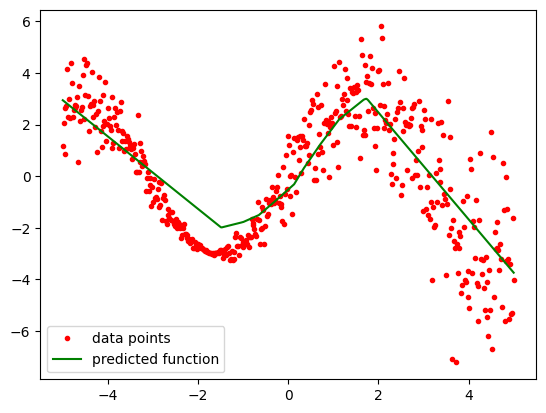

In [60]:
y_pred = pre_train_model(X.to(device)).detach().cpu()

plt.plot(X, y, 'r.', label='data points')
plt.plot(X, y_pred, 'g', label='predicted function')
plt.legend()

The solution is sub optimal. Next we will implement SWA with a constant learning rate.

In [2]:
def swa(pretrained_weights, train_set, update_freq, n_steps):
    model = Model().to(device)
    model.load_state_dict(pretrained_weights)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = torch.nn.MSELoss() 
    w_swa = model.get_weight_vector()

    train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
        
    for i in tqdm(range(n_steps)):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
    
            outputs = model(inputs)
            loss = criterion(outputs, targets) 
    
            loss.backward() 
            optimizer.step()
    
            # instead of capturing weights at each epochs we 
            # maintain a running for faster computation.
            if i % update_freq == 0:
                n_models = i // update_freq
                w = model.get_weight_vector()
                w_swa = (w_swa * n_models + w) / (n_models + 1)
    
    return w_swa

In [10]:
w_swa = swa(pre_train_model.state_dict(), train_set, 10, 30)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 18.86it/s]


create a new model and load the $w_{swa}$ weights.

In [11]:
model_swa = Model().to(device)
model_swa.load_flattened_weights(w_swa)

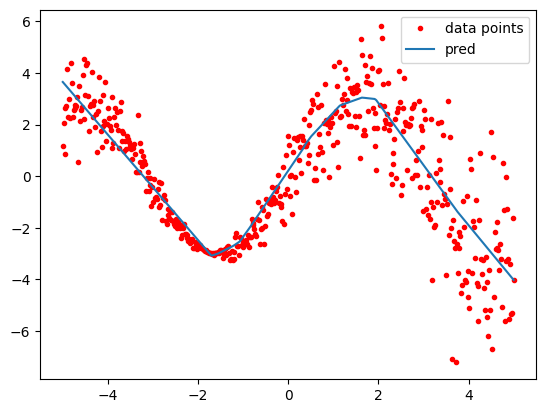

In [12]:
inputs, targets  = train_set[:]
inputs, targets = inputs.to(device), targets.to(device)
pred = model_swa(inputs)

plt.plot(inputs.detach().cpu(), targets.detach().cpu(), 'r.', label='data points')
plt.plot(inputs.detach().cpu(), pred.detach().cpu(), label='pred')
plt.legend()

The model seems to have learned a proper regression curve.

# SWA-Gaussian for Bayesian Deep Learning

Intuitively, SWA computes the mean of the stationary distribution. The stationary distribution refers to the distribution of weights that the model converges after sufficient training. SWA-Gaussian extends SWA by additionally computing the covariance to approximate the posterior distribution over the weights.

## SWAG-Diagonal

The first approach, which is simpler, constructs a diagonal covariance matrix. This is achieved by computing the running average of the second uncentered moment for each weight and constructing the diagonal matrix as follows:

\begin{align*}
\bar{\theta^2} = \frac{1}{T} \sum_{i=1}^T \theta_i^2, \quad \Sigma_{\text{diag}} = \operatorname{diag}(\bar{\theta^2} - \theta_{\text{SWA}}^2)
\end{align*}

The approximate posterior is thus of the form $\mathcal{N}(\theta_{\text{SWA}}, \Sigma_{\text{diag}})$.

![SWAG Diag](SWAG_Diag.png)

In [3]:
def swag_diagonal(pre_trained_weights, train_set, lr, steps, update_freq, opt=torch.optim.SGD, criterion=torch.nn.MSELoss()):
    model = Model().to(device)
    model.load_state_dict(pre_trained_weights)

    # setting initial moments
    w = model.get_weight_vector()
    w_2 = torch.pow(w, 2)
    w_swa = w.clone().to(torch.double)  
    w_swa_2 = w_2.clone().to(torch.double)

    optimizer = opt(model.parameters(), lr=lr)
    data_loader = DataLoader(train_set, batch_size=16, shuffle=True)
    
    for i in tqdm(range(steps)):
        model.train()
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # running average of first and second moments.
        if i % update_freq == 0:
            n_models = i // update_freq
            
            w = model.get_weight_vector()
            w_2 = torch.pow(w, 2)
    
            w_swa = (w_swa * n_models + w) / (n_models + 1)
            w_swa_2 = (w_swa_2 * n_models + w_2) / (n_models + 1)

    #computing variance
    var = w_swa_2 - torch.pow(w_swa, 2) 

    # Due to numerical instability it can happen to have negative variance, 
    # extremely close to 0. To overcome this we apply inplace relu, negative
    # values are set to 0 and postive stays untouched.
    if torch.any(var < 0):
        torch.nn.functional.relu_(var) 
    
    return w_swa, var 		

Once we have the statistics to approximate the posterior as a Gaussian, we can sample a set of weights from this posterior and perform inference via Bayesian Model Averaging (BMA). To sample from the SWAG-diagonal posterior, we use the following identity:

\begin{align*}
    \tilde{\theta} &= \theta_{\text{SWA}} + \frac{1}{\sqrt{2}} \Sigma_{\text{diag}}^{1/2} z_1
\end{align*}

where $z_1 \sim \mathcal{N}(0, I_d)$ and $d$ is the number of parameters in the model.

In practice, due to the diagonal structure of $\Sigma_{\text{diag}}$, we can perform element-wise multiplication instead of matrix multiplication, making this computation efficient with a complexity of $\mathcal{O}(d)$. Consequently, we only need to retain the variance and do not need to expand it into a full diagonal matrix.

In [7]:
#To gain computation time during BMA, the variance is square-rooted before the function call.
def sample_swag_diag(w_swa, sqrt_var_vec):
    z_1 = torch.randn(sqrt_var_vec.size(0), dtype=torch.double, device=sqrt_var_vec.device)
    noise_diag = (1 / np.sqrt(2)) * sqrt_var_vec * z_1
  
    return w_swa + noise_diag

In [17]:
w_swa, var_vec = swag_diagonal(pre_train_model.state_dict(), train_set, 0.01, 50, 10)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.30it/s]


### Bayesian Model Averaging  

Bayesian Model Averaging (BMA) is a method that combines predictions from multiple models by weighing them according to their posterior probabilities, thereby accounting for model uncertainty. In our case, since we have approximated the model's weight posterior distribution, we can sample different sets of weights, perform inference, and average the predictions. This approach allows us to measure the model's uncertainty regarding its weights by computing the deviation of all the predictions.

In [18]:
def bma(X, w_swa, var_vec, n_samples=100):
    preds = None
    model = Model().to(device) 
    sqrt_var_vec = var_vec.sqrt() # var vec is put to sqrt once for all to gain computation time
    for i in tqdm(range(n_samples)):
        sampled_params = sample_swag_diag(w_swa, var_vec)
        model.load_flattened_weights(sampled_params)
        with torch.no_grad():
            model.eval()
            y_pred = model(X)
            
            if preds is None:
                preds = torch.zeros((n_samples, y_pred.size(0), y_pred.size(1)), dtype=y_pred.dtype, device=y_pred.device)
                
            preds[i] = y_pred.detach()

    std_pred, mean_pred = torch.std_mean(preds, dim=0)
    return mean_pred, std_pred, preds

## Testing the model

In [23]:
X_extended = torch.linspace(-10, 10, 500, device=device)
mean_pred, std_pred, preds = bma(X_extended.unsqueeze(1), w_swa, var_vec, n_samples=500)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1186.45it/s]


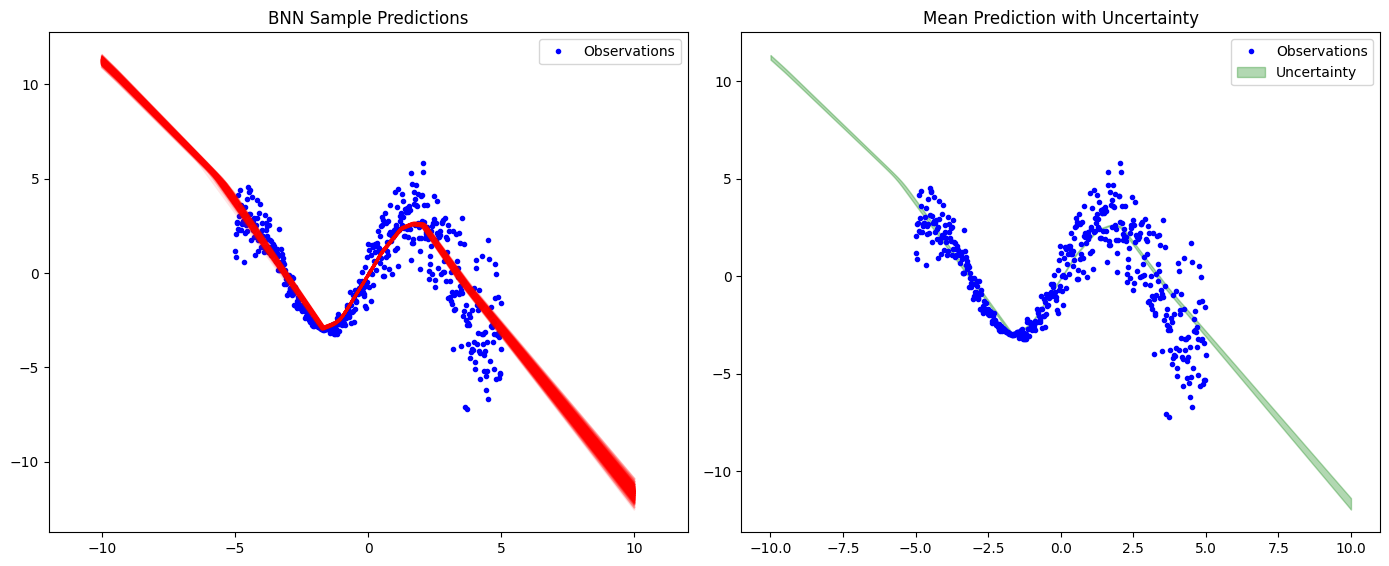

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].set_title('BNN Sample Predictions')
axes[0].set_xlim(-12, 12)
axes[0].plot(X.detach(), y, 'b.', label='Observations')
# axes[0].plot(X_extended.detach().cpu(), mean_pred.detach().cpu(), 'r', label='Mean prediction')
axes[0].legend()

for pred in preds:
    axes[0].plot(X_extended.detach().cpu(), pred.detach().cpu(), 'r', alpha=0.1)

mean_pred = mean_pred.detach().cpu()
std_pred = std_pred.detach().cpu()

axes[1].set_title('Mean Prediction with Uncertainty')
axes[1].plot(X.detach(), y.numpy(), 'b.', label='Observations')
axes[1].fill_between(
    X_extended.detach().cpu().squeeze(),
    (mean_pred - std_pred).squeeze(),
    (mean_pred + std_pred).squeeze(),
    color='g',
    alpha=0.3,
    label='Uncertainty'
)
axes[1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

prediction is correct, but uncertainty isn't very relevant, SWAG diag hasn't properly approximated the posterior distribution.

# SWAG low rank plus 

The full SWAG algorithm extends the diagonal covariance approximation with a low-rank plus diagonal covariance. The sample covariance of the SGD iterates can be written as the sum of outer products:

\begin{align*}
    \Sigma = \frac{1}{T-1} \sum_{i=1}^T (\theta_i - \theta_{\text{SWA}})( \theta_i - \theta_{\text{SWA}})^{\top} 
\end{align*}

Since $\theta_{\text{SWA}}$ is not accessible during training, we approximate the covariance as:

\begin{align*}
    \Sigma \approx \frac{1}{T-1} (\theta_i - \bar{\theta_i})(\theta_i - \bar{\theta_i})^{\top} = \frac{1}{T-1} DD^{\top}
\end{align*}

where $D$ is the deviation matrix with columns $D_i = (\theta_i - \bar{\theta}_i)$ and $\bar{\theta}_i$ is the running average. As storing all the deviations can be too complex in terms of space, we keep the last $K$ deviations of training, resulting in the low-rank approximation:

\begin{align*}
\Sigma_{\text{low-rank}} = \frac{1}{K-1} \cdot \hat{D} \hat{D}^{\top}
\end{align*}

where $\hat{D}$ is composed of the deviations from the last $K$ steps.


![SWAG low rank](SWAG.png)

In [9]:
def swag_low_rank(pre_trained_weights, train_set, lr, steps, update_freq, K, opt=torch.optim.SGD, criterion=torch.nn.MSELoss()):
    if K > steps:
        raise ValueError(f'Steps must be superior to K, got {steps}, {K}')
    
    model = Model().to(device)
    model.load_state_dict(pre_trained_weights)

    # setting initial moments
    w = model.get_weight_vector()
    w_2 = torch.pow(w, 2)
    w_swa = w.clone().to(torch.double)  
    w_swa_2 = w_2.clone().to(torch.double)
    
    D = torch.zeros((w_swa.size(dim=0), K), dtype=torch.double, device=device)

    optimizer = opt(model.parameters(), lr=lr)
    data_loader = DataLoader(train_set, batch_size=16, shuffle=True)

    for i in tqdm(range(steps)):
        model.train()
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
        if i % update_freq == 0:
            n_models = i // update_freq  
            
            w = model.get_weight_vector()
            w_2 = torch.pow(w, 2)
    
            w_swa = (w_swa * n_models + w) / (n_models + 1)
            w_swa_2 = (w_swa_2 * n_models + w_2) / (n_models + 1)

            col_idx = n_models % K
            if n_models % K == 0 and n_models > 0:
                D[:, :-1] = D[:, 1:] 
                D[:, -1] = 0
            D[:, col_idx] = w - w_swa
    
    var = w_swa_2 - torch.pow(w_swa, 2) 

    # Due to numerical instability it can happen to have negative variance, 
    # extremely close to 0. To overcome this we apply inplace relu, negative
    # values are set to 0 and postive stays untouched.
    if torch.any(var < 0):
        torch.nn.functional.relu_(var) 
    
    return w_swa, var, D

In [62]:
w_swa, var_vec, D = swag_low_rank(pre_train_model.state_dict(), train_set, 0.01, 50, 10, 25)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.69it/s]


The approximate posterior is now of the form:

\begin{align*}
    \mathcal{N}(\theta_{\text{SWA}}, \frac{1}{2} \cdot (\Sigma_{\text{diag}} + \Sigma_{\text{low-rank}})).
\end{align*}

To sample from it, we update the identity:

\begin{align*}
    \tilde{\theta} &= \theta_{\text{SWA}} + \frac{1}{\sqrt{2}} \Sigma_{\text{diag}}^{1/2} z_1 + \frac{1}{\sqrt{2(K-1)}} D z_2.
\end{align*}

with $z_2 \sim \mathcal{N}(0, I_K)$.


In [29]:
def sample_swag(w_swa, sqrt_var_vec, D):
    z_1 = torch.randn(sqrt_var_vec.size(0), dtype=torch.double, device=sqrt_var_vec.device)
    noise_diag = (1 / np.sqrt(2)) * sqrt_var_vec * z_1
    
    K = D.size(dim=1)
    z_2 = torch.randn(K, dtype=torch.double, device=D.device)
    noise_low_rank = (1 / np.sqrt(K - 1)) * D @ z_2
    
    posterior_noise = noise_diag + noise_low_rank

    return w_swa + posterior_noise

In [28]:
def bma(X, w_swa, var_vec, D, n_samples=100):
    preds = None
    model = Model().to(device) 
    sqrt_var_vec = var_vec.sqrt()
    for i in tqdm(range(n_samples)):
        sampled_params = sample_swag(w_swa, sqrt_var_vec, D)
        model.load_flattened_weights(sampled_params)
        with torch.no_grad():
            model.eval()
            y_pred = model(X)
            
            if preds is None:
                preds = torch.zeros((n_samples, y_pred.size(0), y_pred.size(1)), dtype=y_pred.dtype, device=y_pred.device)
                
            preds[i] = y_pred.detach()

    std_pred, mean_pred = torch.std_mean(preds, dim=0)
    return mean_pred, std_pred, preds

### Testing the model

In [64]:
X_extended = torch.linspace(-10, 10, 500, device=device)
mean_pred, std_pred, preds = bma(X_extended.unsqueeze(1), w_swa, var_vec, D, n_samples=500)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1082.54it/s]


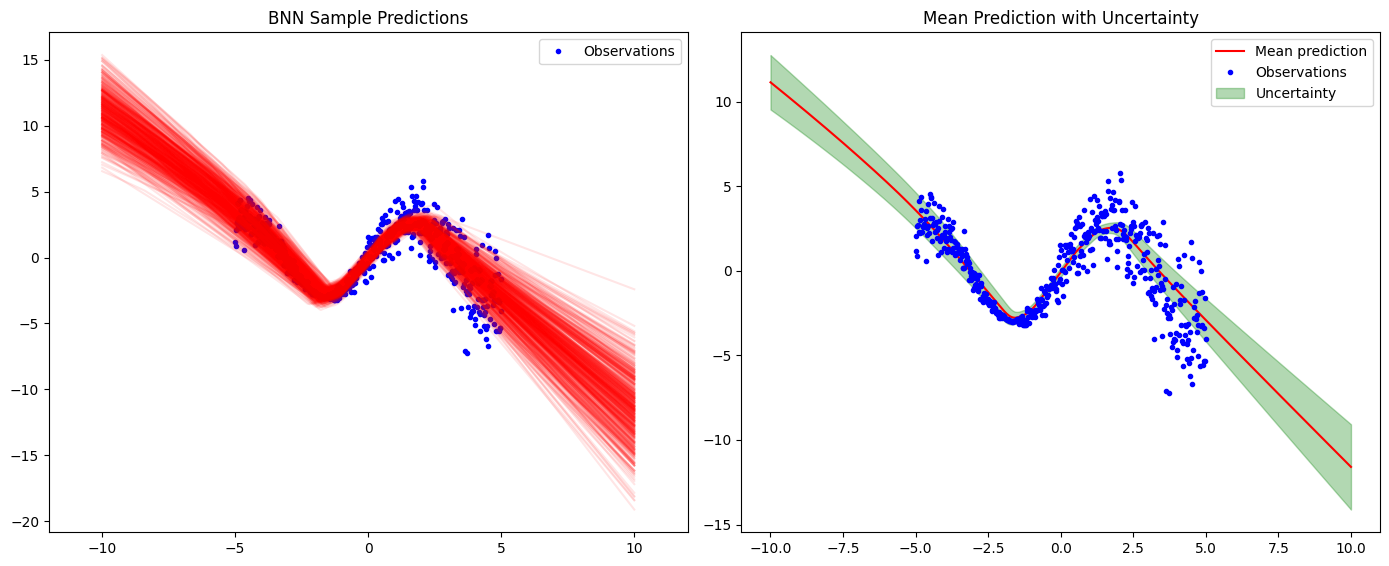

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].set_title('BNN Sample Predictions')
axes[0].set_xlim(-12, 12)
axes[0].plot(X.detach(), y, 'b.', label='Observations')
axes[0].legend()

for pred in preds:
    axes[0].plot(X_extended.detach().cpu(), pred.detach().cpu(), 'r', alpha=0.1)

mean_pred = mean_pred.detach().cpu()
std_pred = std_pred.detach().cpu()

axes[1].set_title('Mean Prediction with Uncertainty')
axes[1].plot(X_extended.detach().cpu(), mean_pred.detach().cpu(), 'r', label='Mean prediction')
axes[1].plot(X.detach(), y.numpy(), 'b.', label='Observations')
axes[1].fill_between(
    X_extended.detach().cpu().squeeze(),
    (mean_pred - std_pred).squeeze(),
    (mean_pred + std_pred).squeeze(),
    color='g',
    alpha=0.3,
    label='Uncertainty'
)
axes[1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Now the BMA yields a more coherent uncertainty while producing a correct estimate of the function.

# MNIST

Let's apply SWAG to a more complexe classification dataset.

In [12]:
transform = transforms.Compose([transforms.ToTensor()])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

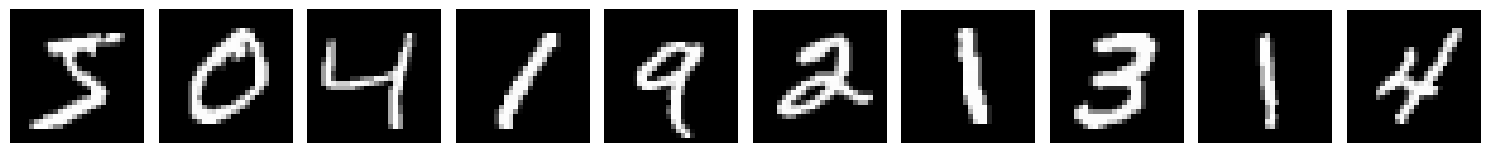

In [13]:
fig, axs = plt.subplots(1, 10, figsize=(15, 6))
for i in range(10):
    image, _ = mnist_train[i]
    axs[i].imshow(image.squeeze(), cmap='gray') 
    axs[i].axis('off')  
    
plt.tight_layout()
plt.show()

In [14]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.dense1 = torch.nn.Linear(784, 64)  
        self.dense2 = torch.nn.Linear(64, 10)  

    def forward(self, x):
        out = self.flatten(x)
        out = self.dense1(out)
        out = torch.nn.functional.relu(out) 
        out = self.dense2(out)
        out = torch.nn.functional.softmax(out, dim=1)  
        return out
    
    def load_flattened_weights(self, flattened_weights):
        idx = 0
        with torch.no_grad():
            for param in self.parameters():
                num_w = param.numel()
                vec = flattened_weights[idx:idx+num_w]
                param.copy_(vec.view_as(param))
                
                idx += num_w
    
    def get_weight_vector(self):
        return torch.cat([params.view(-1) for params in self.parameters()])

## Pre train the model

In [21]:
epochs = 20

In [22]:
pre_train_model = Model().to(device)
pre_train_model.train()  
optimizer = torch.optim.Adam(pre_train_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss() 

train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)

for epoch in tqdm(range(epochs)):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  
        optimizer.zero_grad()
        outputs = pre_train_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:22<00:00,  7.11s/it]


In [23]:
pre_train_model.eval()

X_test, y_test = mnist_test.data, mnist_test.targets.to(device)
X_test = X_test.view(X_test.size(0), -1).to(device)  

correct = 0
total = 0

with torch.no_grad():
    outputs = pre_train_model(X_test.float()) 
    _, predicted = torch.max(outputs.data, 1) 

    total = y_test.size(0)  
    correct = (predicted == y_test).sum().item()  

accuracy = correct / total * 100  
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 96.39%


In [24]:
pre_trained_weights = pre_train_model.state_dict()

In [25]:
w_swa, var, D = swag_low_rank(pre_trained_weights, mnist_train, lr=0.01, steps=50, update_freq=10, K=25, opt=torch.optim.Adam, criterion=torch.nn.CrossEntropyLoss())

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:52<00:00, 11.85s/it]


In [26]:
X_test = mnist_test.data.float().to(device)

In [30]:
mean_pred, std_pred, preds = bma(X_test, w_swa, var, D, n_samples=500)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 842.13it/s]


In [31]:
X_test, y_test = mnist_test.data , mnist_test.targets
X_test = X_test.view(X_test.size(0), -1).to(device)
    
predicted = torch.argmax(mean_pred, 1).cpu()

total = y_test.size(0)  
correct = (predicted == y_test).sum().item()  
accuracy = correct / total * 100  
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 95.46%


Now we can take a look at the model predictions and it's uncerainty

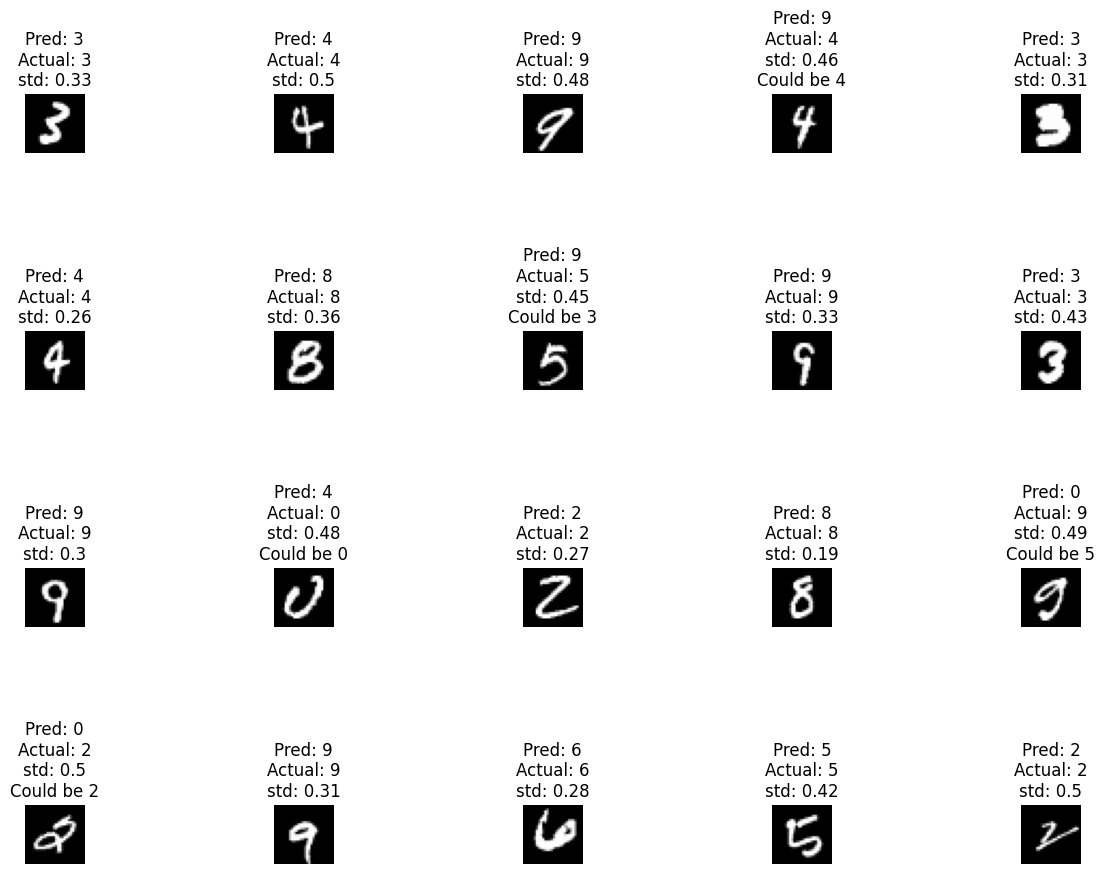

In [33]:
random_indices = np.random.permutation(len(std_pred))

fig, axs = plt.subplots(4, 5, figsize=(15, 10))

plotted_images = 0
max_images = 20  

for i in random_indices:
    std = std_pred[i]
    if sum(std) > 0.5: 
        row = plotted_images // 5
        col = plotted_images % 5  
        
        axs[row, col].imshow(X_test[i, :].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        axs[row, col].axis('off') 

        actual_label = y_test[i].item()
        predicted_label = torch.argmax(mean_pred[i]).item()
        _, other_labels = torch.topk(std_pred[i], 2)

        if actual_label != predicted_label:
            axs[row, col].set_title(f"Pred: {predicted_label}\nActual: {actual_label}\nstd: {np.round(std_pred[i, predicted_label].item(), decimals=2)}\nCould be {other_labels[-1].item()}")
        else: 
            axs[row, col].set_title(f"Pred: {predicted_label}\nActual: {actual_label}\nstd: {np.round(std_pred[i, predicted_label].item(), decimals=2)}")

        plotted_images += 1
        
        if plotted_images >= max_images:
            break

plt.subplots_adjust(wspace=0.5, hspace=3) 
plt.show()

Here are displayed some outputs with high uncertainty. When the prediction is incorrect, we display the label with the highest uncertainty, aside the predicted one. Overall uncertainty is higher for digits with unusual shapes.